## Проектная работа:

### Описание проекта ###

Развлекательное приложение Procrastinate Pro+ несколько прошлых месяцев постоянно терпит убытки. Необходимо разобраться в причинах убыточночти рекламных кампаний.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Обзор данных ## 


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
import re
import warnings
warnings.filterwarnings("ignore")

In [77]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

### Обзор данных visits ###

In [78]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [79]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [80]:
visits['Channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Привдем названия столбцов к типу snake-case и изменим Session Start и Session End к типу datetime
Пропусков в данных нет

In [81]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [82]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [83]:
visits.duplicated().sum()

0

### Обзор данных orders ###

In [84]:
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [85]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Привдем названия столбцов к типу snake-case и изменим Event Dt к типу datetime

In [86]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

In [87]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [88]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [89]:
orders.duplicated().sum()

0

### Обзор данных costs ###

In [90]:
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [91]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Привдем названия столбцов к типу snake-case и изменим dt к типу date

In [92]:
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

In [93]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [94]:
costs.duplicated().sum()

0

Данные в трех таблицах проверены на дубликаты. Таковых не найдено

## Функции для расчета и анализа LTV, ROI, удержания и конверсии ##



### Функция для создания пользовательских профилей ###

In [95]:
def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для подсчета LTV  и ROI ###

In [96]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для расчёта удержания ###

In [97]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта конверсии ###

In [98]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

## Проведение исследовательского анализа данных ##


### Определите минимальную и максимальную даты привлечения пользователей. ###

In [99]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [100]:
min_date = profiles['first_ts'].dt.date.min()
min_date

datetime.date(2019, 5, 1)

In [101]:
observation_date = profiles['first_ts'].dt.date.max()
observation_date

datetime.date(2019, 10, 27)

In [102]:
horizon_days = 14

In [103]:
observation_date - timedelta(
            days=horizon_days - 1
        )

datetime.date(2019, 10, 14)

### Анализ количества пользователей и доли платящих из каждой страны. ###

In [104]:
profiles_region = (profiles.groupby('region').agg({'user_id':'nunique', 'payer': 'sum'})
                                            .reset_index()
                                            .sort_values(by='user_id', ascending=False)
                  )
profiles_region['share'] = round((profiles_region['payer'] / profiles_region['user_id'])*100, 2)
profiles_region

region  user_id  payer  share
3  United States   100002   6902   6.90
2             UK    17575    700   3.98
0         France    17450    663   3.80
1        Germany    14981    616   4.11

Больше всего пользователей у нас из США с очень большим отрывом, но всего 6.9% зашедших на сайт из США что-то покупают
В остальных странах количество посетителей примерно одинаково и покупателями становятся от 3.8% до 4.11%
Хотелось бы отдельно выделить Германию, из нее меньше всего пользователей, но покупателей больше чем в Англии и Франции

### Анализ количества пользователей и доли платящих для каждого устройства ###

In [105]:
profiles_device = (profiles.groupby('device').agg({'user_id':'nunique', 'payer': 'sum'})
                                            .reset_index()
                                            .sort_values(by='user_id', ascending=False)
                  )
profiles_device['share'] = round((profiles_device['payer'] / profiles_device['user_id'])*100, 2)
profiles_device

device  user_id  payer  share
3   iPhone    54479   3382   6.21
0  Android    35032   2050   5.85
2       PC    30455   1537   5.05
1      Mac    30042   1912   6.36

В данныз мы видим, что пользователей, которые заходят с Айфонов больше всего, но больше всего платящих у нас в группе пользоватеелй Mac

### Анализ количества пользователей и доли платящих для каждого канала привлечения. ###

In [106]:
profiles_channel = (profiles.groupby('channel').agg({'user_id':'nunique', 'payer': 'sum'})
                                            .reset_index()
                                            .sort_values(by='user_id', ascending=False)
                  )
profiles_channel['share'] = (profiles_channel['payer'] / profiles_channel['user_id'])*100
profiles_channel

channel  user_id  payer      share
10             organic    56439   1160   2.055316
1             FaceBoom    29144   3557  12.204914
6               TipTop    19561   1878   9.600736
4   OppleCreativeMedia     8605    233   2.707728
2              LeapBob     8553    262   3.063253
7       WahooNetBanner     8553    453   5.296387
5       RocketSuperAds     4448    352   7.913669
3         MediaTornado     4364    156   3.574702
8              YRabbit     4312    165   3.826531
0           AdNonSense     3880    440  11.340206
9       lambdaMediaAds     2149    225  10.469986

Очень большое количество пользователей у нас приходят из канала organic, неплохие результаты, ведь эти пользователи бесплатные. Но почему то они очень плохо покупают всего 2% от всех зашедших
Много посетителей на сайт заходят с каналов FaceBoom и TipTop, но рекламные каналы которые у нас на последнем месте AdNonSense и lambdaMediaAds догоняют и опережают по проценту платящих пользователей

## Маркетинг ##


### Распределение трат на маркетинг по источникам. ###

In [107]:
round(costs['costs'].sum(),2)

105497.3

In [108]:
round(profiles['acquisition_cost'].sum(),2)

105497.3

При составлении профилей пользователей расчеты были проведены верны и информация не потерялась. Цифры сходятся

In [109]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month

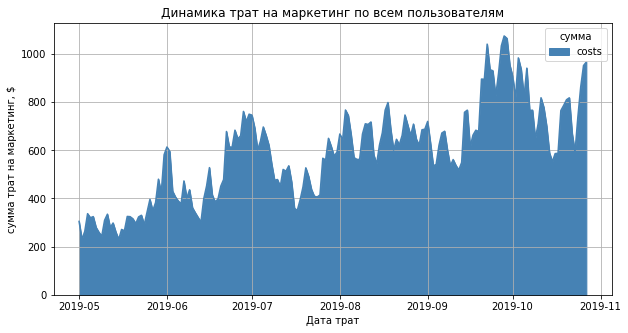

In [110]:
costs.pivot_table(index='dt', values='costs', aggfunc='sum').plot(kind='area', grid=True, figsize=(10, 5), color="steelblue")
plt.ylabel('сумма трат на маркетинг, $')
plt.xlabel('Дата трат')
plt.legend(title='сумма')
plt.title('Динамика трат на маркетинг по всем пользователям')
plt.show()

Как мы видим по графику, траты на маркетинг каждый месяц увеличиваются

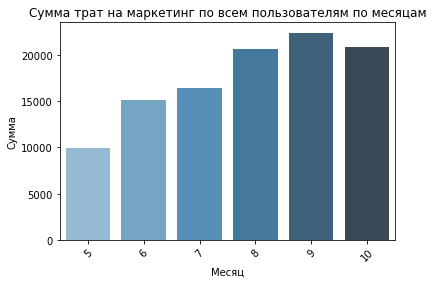

In [111]:
b = costs.groupby('month',as_index=False)['costs'].sum()
fig, ax = plt.subplots(figsize=(6,4))     
plt.xticks(rotation = 45)
sns.barplot(x=b['month'], y=b['costs'], palette="Blues_d");
ax.set_title('Сумма трат на маркетинг по всем пользователям по месяцам');
plt.xlabel('Месяц');
plt.ylabel('Сумма');

Каждый месяц итоговые траты на рекламу стабильно увеличиваются

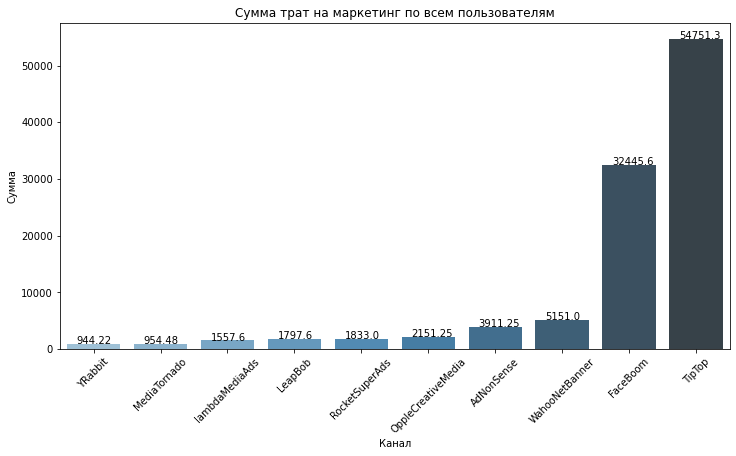

In [112]:
d = costs.groupby('channel',as_index=False)['costs'].sum().sort_values(by='costs')
fig, ax = plt.subplots(figsize=(12,6))     
plt.xticks(rotation = 45)
sns.barplot(x=d['channel'], y=d['costs'], palette="Blues_d");
for p, label in zip(ax.patches, round(d['costs'], 2)):
    ax.annotate(label, (p.get_x()+0.150, p.get_height()+0.7));
ax.set_title('Сумма трат на маркетинг по всем пользователям');
plt.xlabel('Канал');
plt.ylabel('Сумма');

Самые дорогие каналы привлечения у нас вышли TipTop и FaceBoom

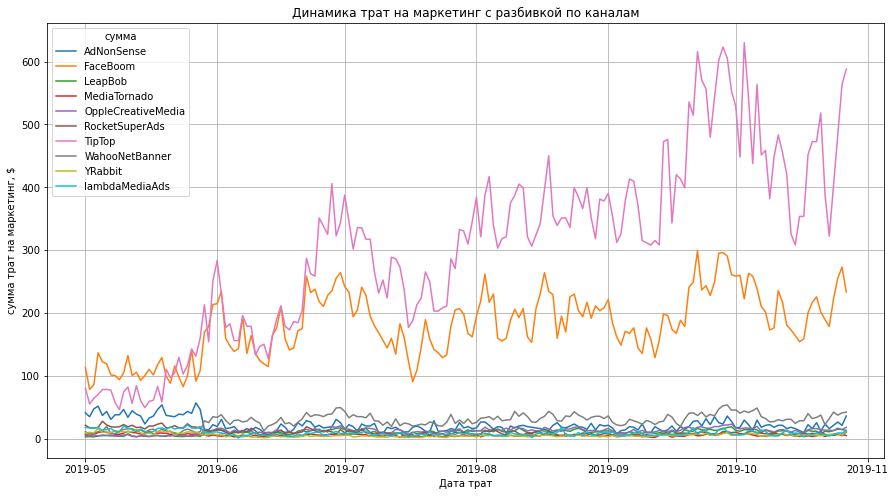

In [113]:
costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15, 8))
plt.ylabel('сумма трат на маркетинг, $')
plt.xlabel('Дата трат')
plt.legend(title='сумма')
plt.title('Динамика трат на маркетинг с разбивкой по каналам')
plt.show()

In [114]:
table = costs.query('channel != "TipTop" and channel != "FaceBoom"').pivot_table(index='dt', 
                                                                                 columns='channel', 
                                                                                 values='costs', 
                                                                                 aggfunc='sum')

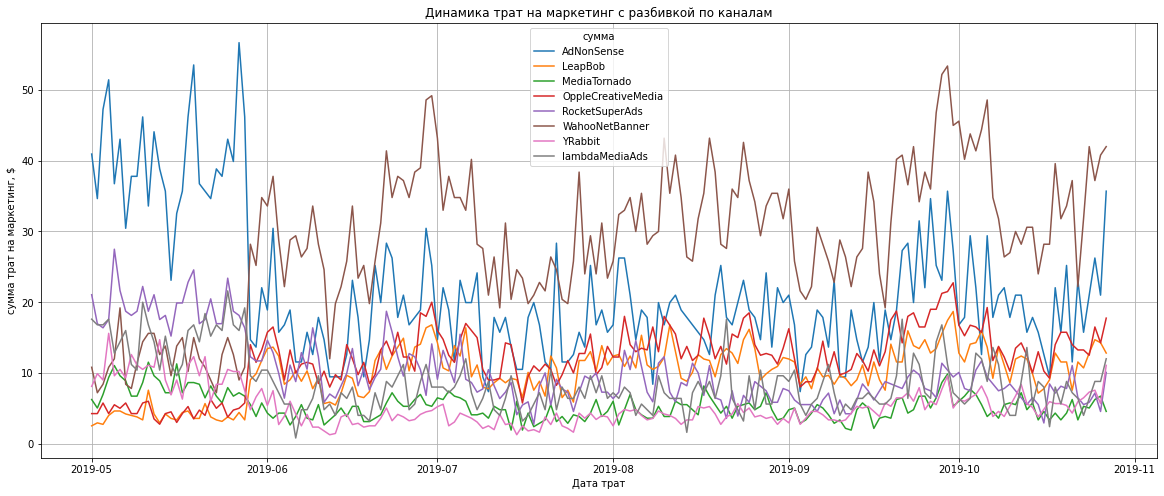

In [115]:
table.plot(grid=True, figsize=(20, 8))
plt.ylabel('сумма трат на маркетинг, $')
plt.xlabel('Дата трат')
plt.legend(title='сумма')
plt.title('Динамика трат на маркетинг с разбивкой по каналам')
plt.show()

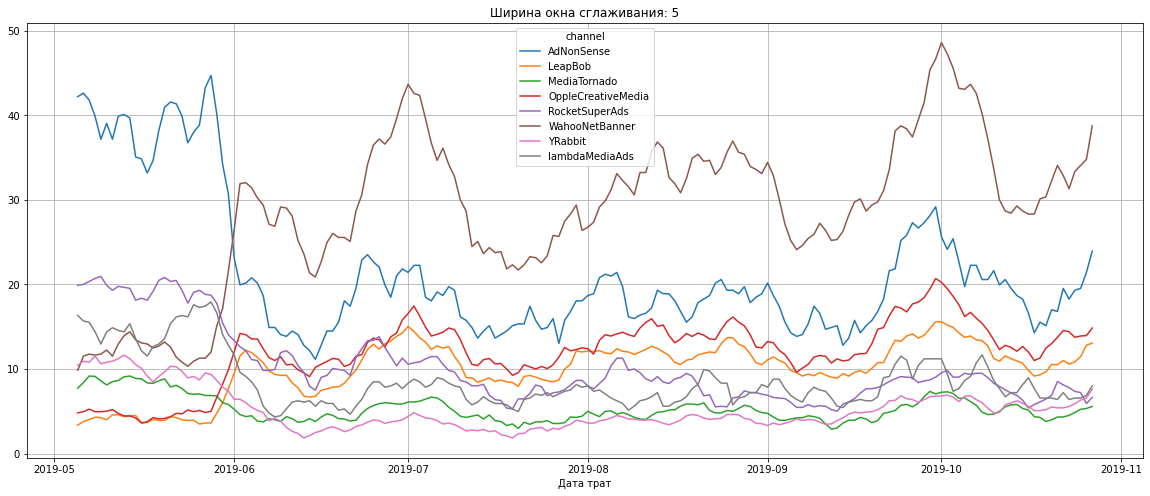

In [116]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

window = 5
filter_data(table, window).plot(grid = True, figsize=(20, 8))
plt.title('Ширина окна сглаживания: {}'.format(window))
plt.xlabel('Дата трат')
plt.show() 

Мы наблюдаем постоянное увелечение бюджета на маркетинг, каждый месяц траты становятся все больше.
При подробном изучении данных мы увидили, что траты повышаются только по 2 каналам привлечения TipTop и FaceBoom
По остальным бюджет иногда меняется, но остается в определенных рамках. Сильных скачков не наблюдается

### Cреднем стоимость привлечения одного пользователя из каждого источника. Cредний CAC на одного пользователя для всего проекта и для каждого источника трафика. ###

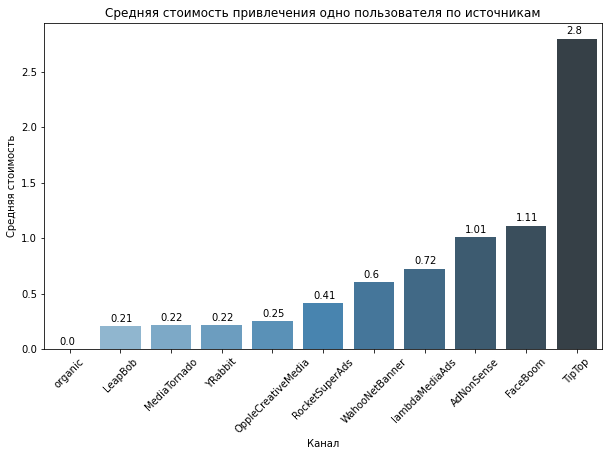

In [117]:
f = profiles.groupby('channel',as_index=False)['acquisition_cost'].mean().sort_values(by='acquisition_cost')
fig, ax = plt.subplots(figsize=(10,6))     
plt.xticks(rotation = 45)
ax = sns.barplot(x=f['channel'], y=f['acquisition_cost'], palette="Blues_d", data=f);
for p, label in zip(ax.patches, round(f['acquisition_cost'], 2)):
    ax.annotate(label, (p.get_x()+0.200, p.get_height()+0.04));
ax.set_title('Средняя стоимость привлечения одно пользователя по источникам');
plt.xlabel('Канал');
plt.ylabel('Средняя стоимость');

In [118]:
round(profiles.query('channel != "organic"')['acquisition_cost'].mean(),2)

1.13

средний CAC на одного пользователя для всего проекта

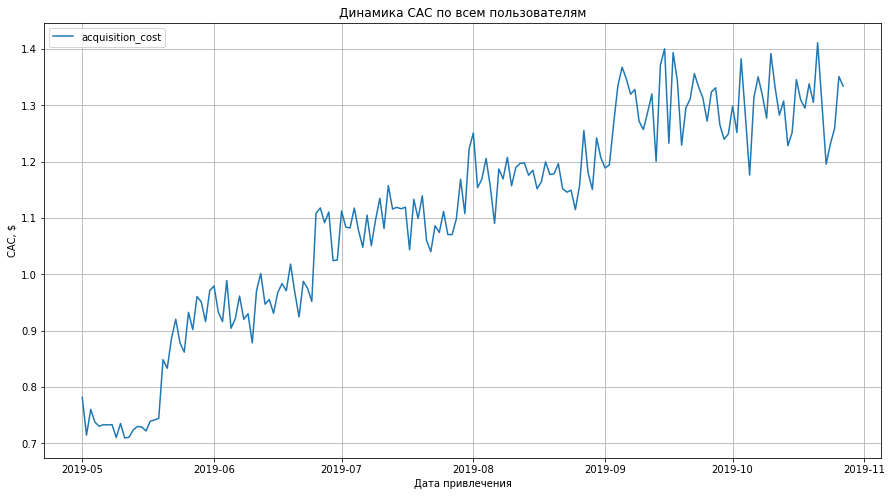

In [119]:
profiles.query('channel != "organic"').pivot_table(
    index='dt', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по всем пользователям')
plt.show()

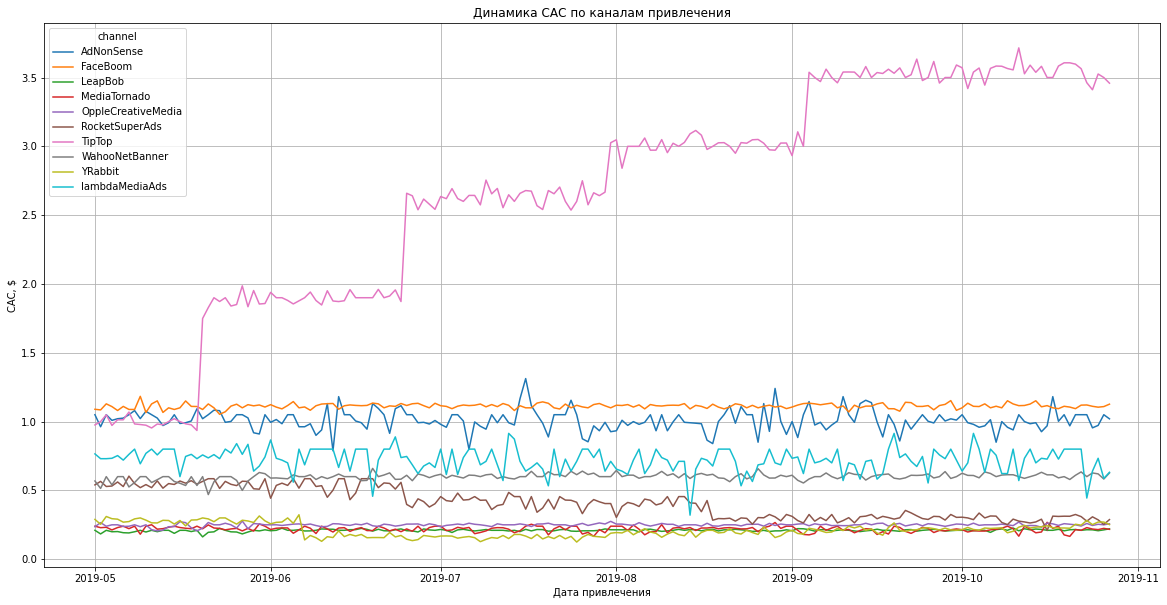

In [120]:
profiles.query('channel != "organic"').pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Стоимость превлечения одного клиента резко выросла в июне, тогда же, когда увеличился бюджет по 2 каналам привлечения TipTop и FaceBoom. Но CAC увеличивается только по каналу TipTop, хоть затраты на FaceBoom и стали больше, но в целом стоимость привлечения остались преждими.

Значит каждым увелечением бюджета по каналу TipTop, увеличивалась стоиомсть клиента. 

Значит клиентов не становилось больше в достаточном количестве, чтобы оправдывать большие траты

## Оценка окупаемости рекламы ##

### Функция для визуализации LTV и ROI ###

In [121]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


### Анализ общей окупаемости рекламы. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI. ###

In [122]:
profiles_good = profiles.query('channel != "organic"')

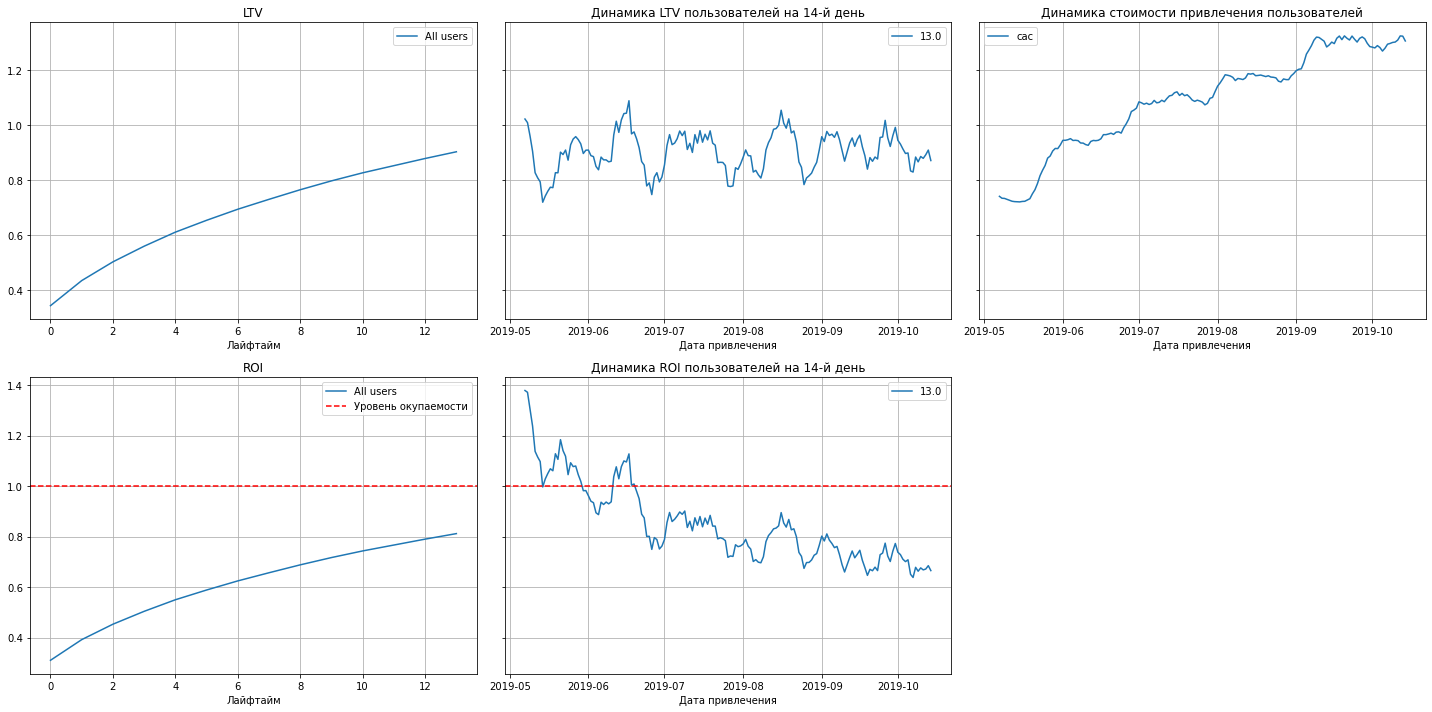

In [123]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good, orders, observation_date, horizon_days
)


plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Реклама не окупается везде, ROI доходит к концу недели до 80%

CAC не стабилен, т.к. мы имеем увелечение рекламного бюджета

Реклама окупалась до июня месяца, далее компания не смогла привлечь достаточное количество пользователей

### Анализ окупаемости рекламы с разбивкой по устройствам

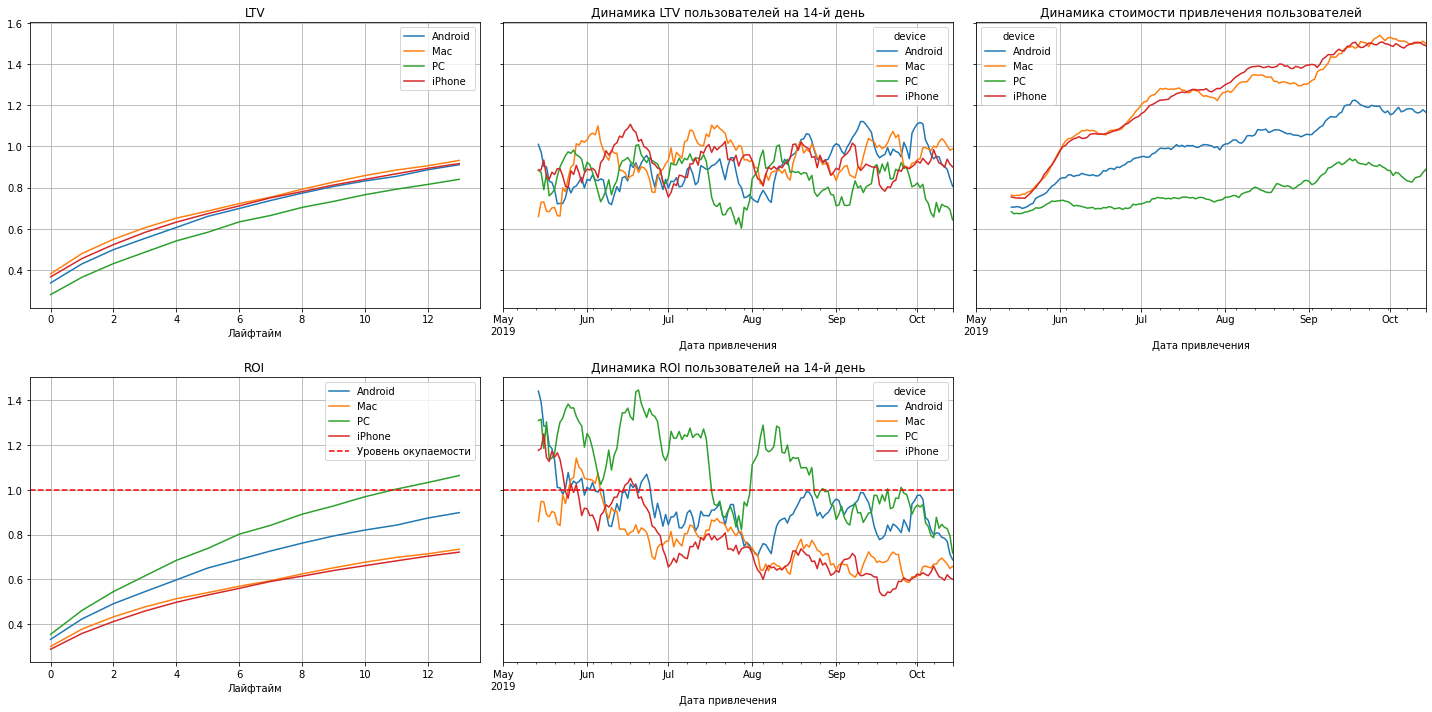

In [124]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи разных устройст приносят одинаковое количество прибыли
LTV стабилен

Реклама окупается за 14 дней только по пользователям PC

До июня у нас окупались пользовтели по всем девайсам кроме MAC, после картина стала хуже. К сентябрю перестали окупаться и поьзователи PC

Стоимость привлечения растет, больше всего по MAC и Iphone

### Проанализируйте окупаемость рекламы с разбивкой по странам

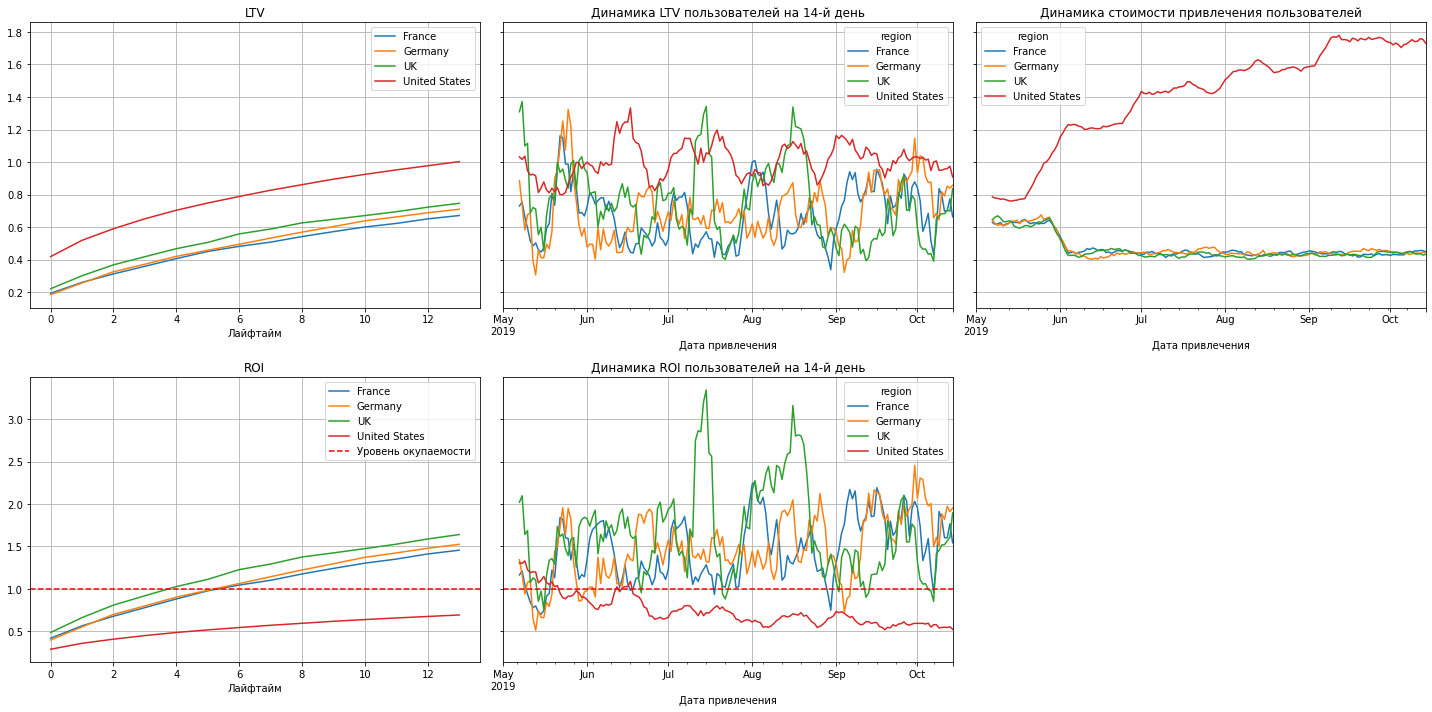

In [125]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
) 

Пользователи США приносят больше всего прибыли, но абсолютно не окупаются. На их привлечение тратится огромная сумма денег, которая с каждым месяцем все растет.

Пользователи из других стран окупаются, но на их привлечение тратится меньше денег, даже в июне было сокращение бюджета на рекламу, но окупаемость все равно выросла

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

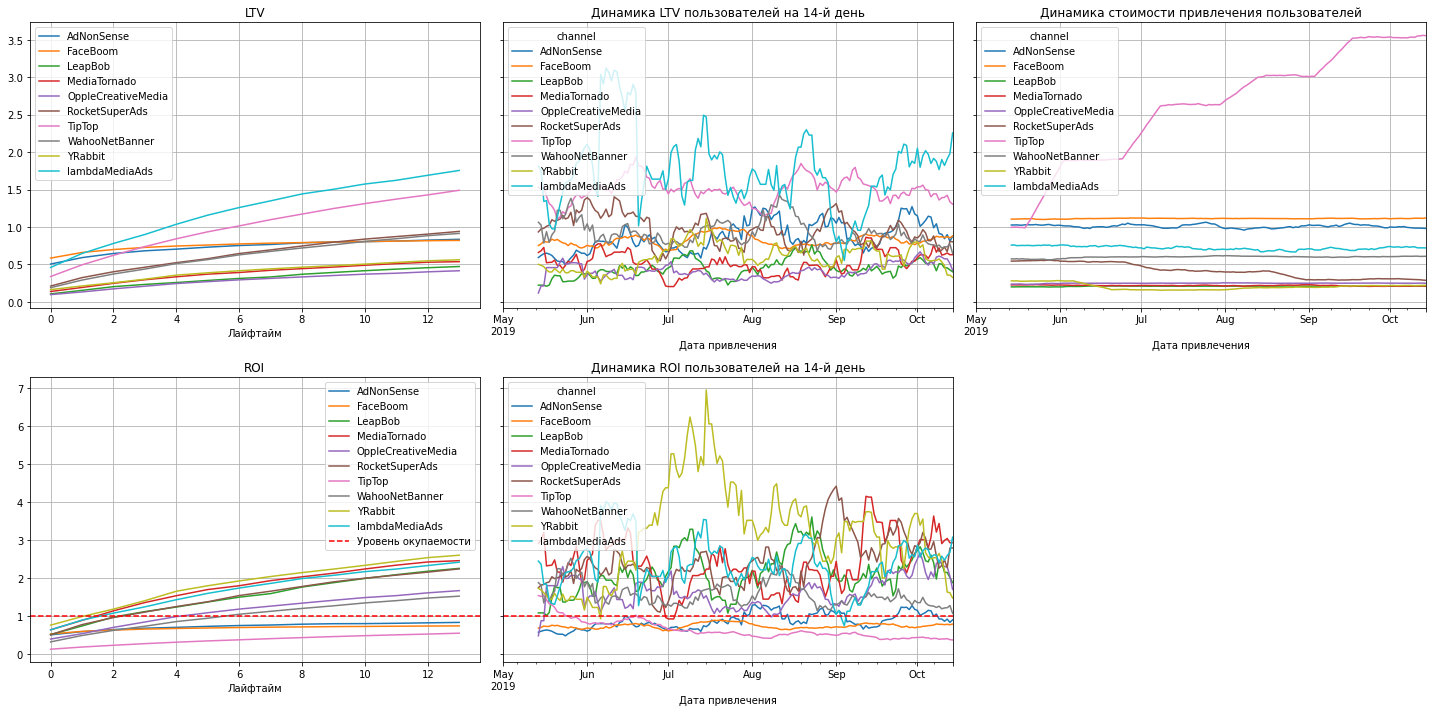

In [126]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Траты на канал привлечения TipTop улетают к октябрю в самый край окна графиков. Данный канал не приносит нужной окупаемости и не соотвествует тем затратам, которые на него приходятся
Всего не окупаются 3 канала FaceBoom, AdNonSense и TipTop

Лучше всего себя показывает YRabbit, его пользователи стоят меньше всего и лучше всего окупаются.


### Анализ окупаемости рекламы в США

In [127]:
profiles_good_USA = profiles_good.query('region == "United States"')

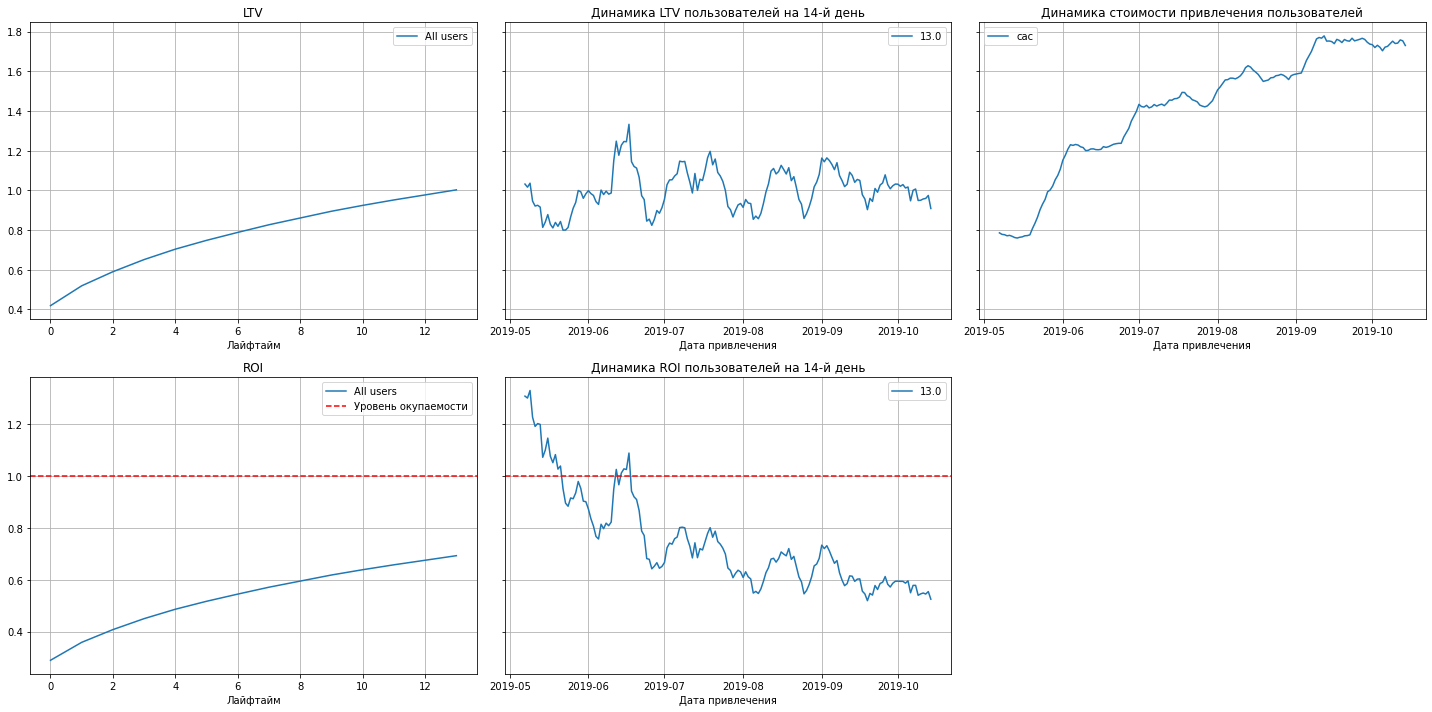

In [128]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good_USA, orders, observation_date, horizon_days
)


plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

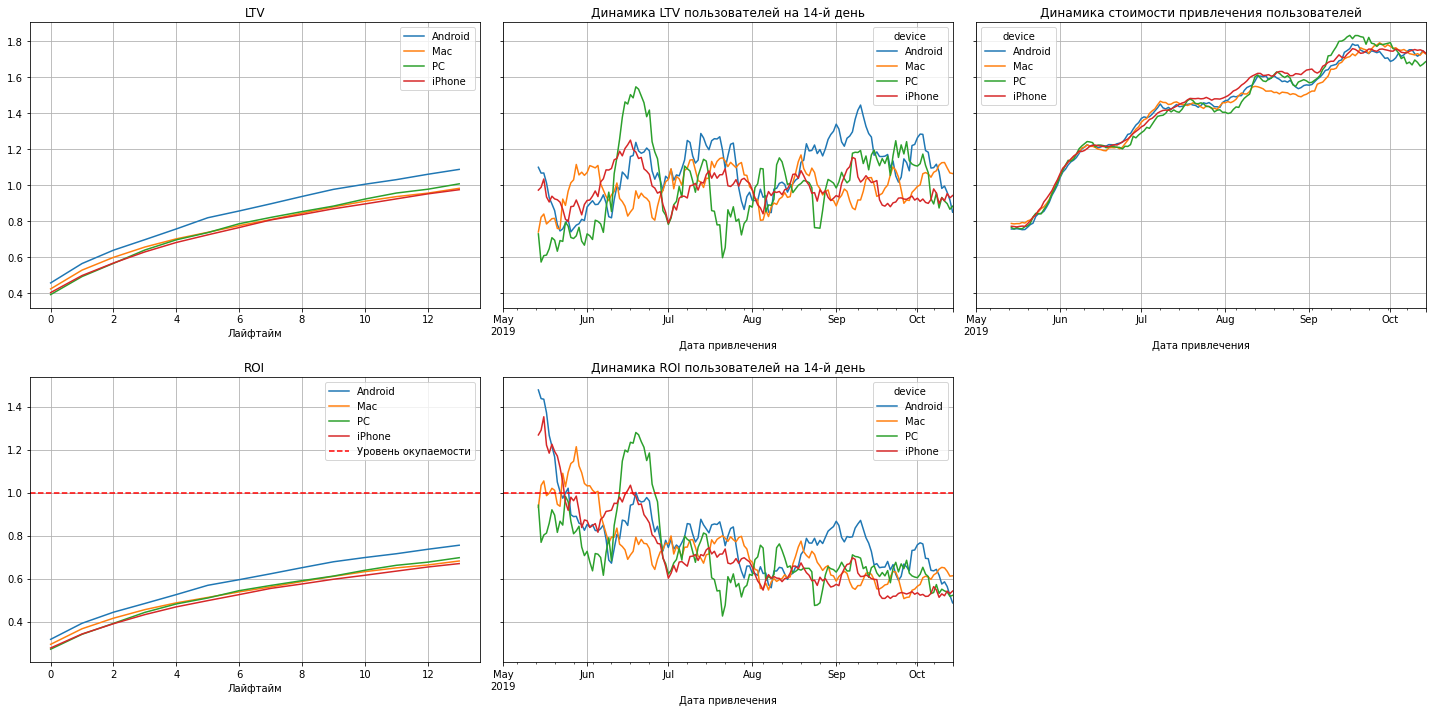

In [129]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good_USA, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

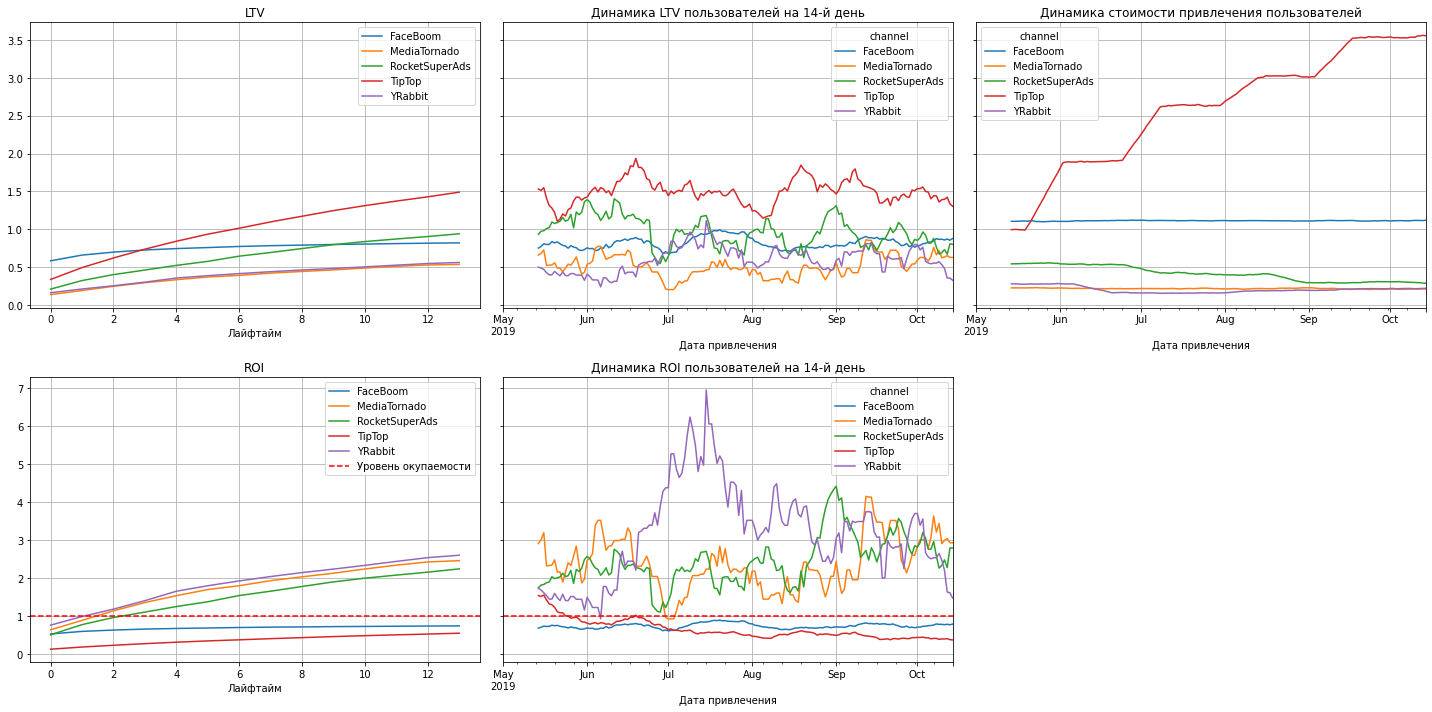

In [130]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good_USA, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По региону США мы видим следующие проблемы, окупаемость очень плохая. Нет зависимости от того, с какого устройства был произведен вход. Оновная проблема в 2 каналах TipTop и FaceBoom. Они не окупаются ни разу за весь период анализа

### Анализ окупаемости рекламы в остальных регионах

In [131]:
profiles_good_europ = profiles_good.query('region != "United States"')

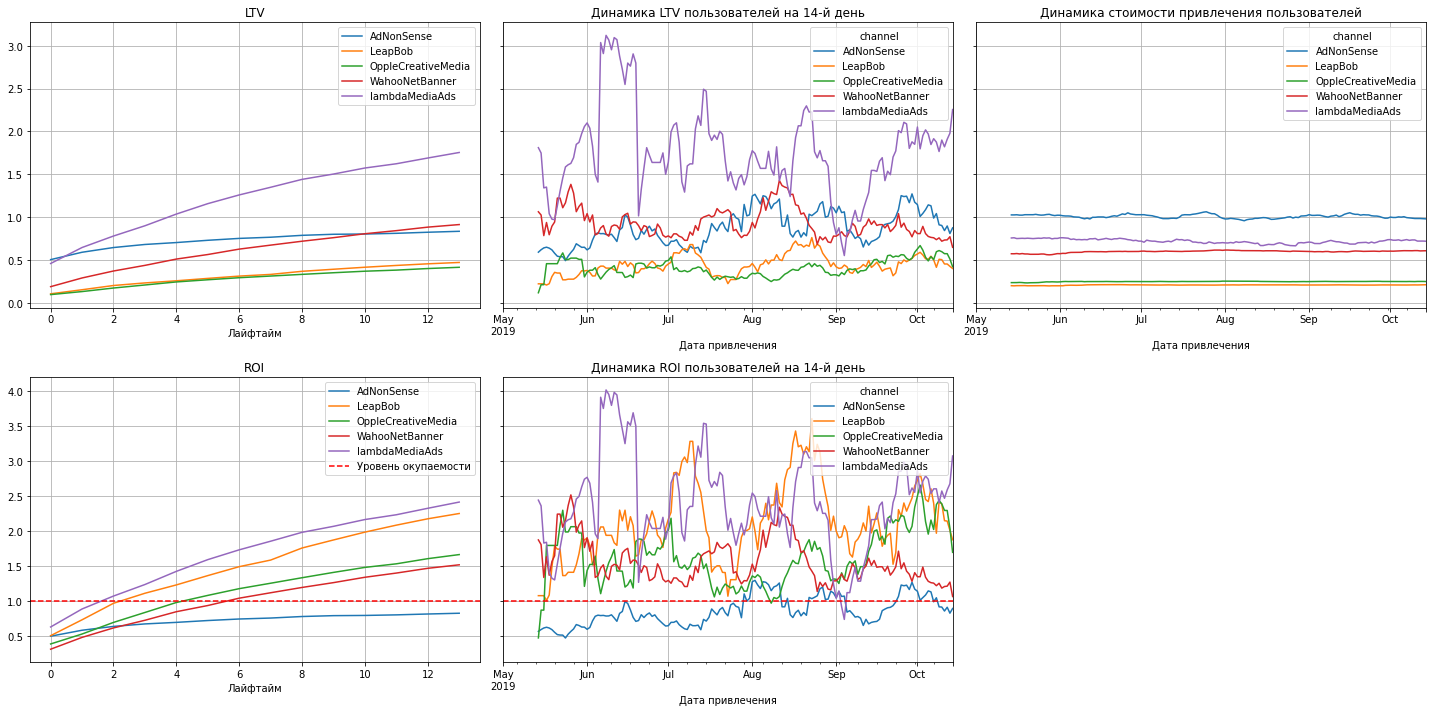

In [132]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_good_europ, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По остальным регионам у нас хорошие опказатели окупаемости, AdNonSense только не окупил вложения. Повышения рекламных бюджетов не наблюдается, самые хорошие показатели у LambdaMediaAds 

### Функция для визуализации удержания ###

In [133]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для визуализации конверсии ###

In [134]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам ###

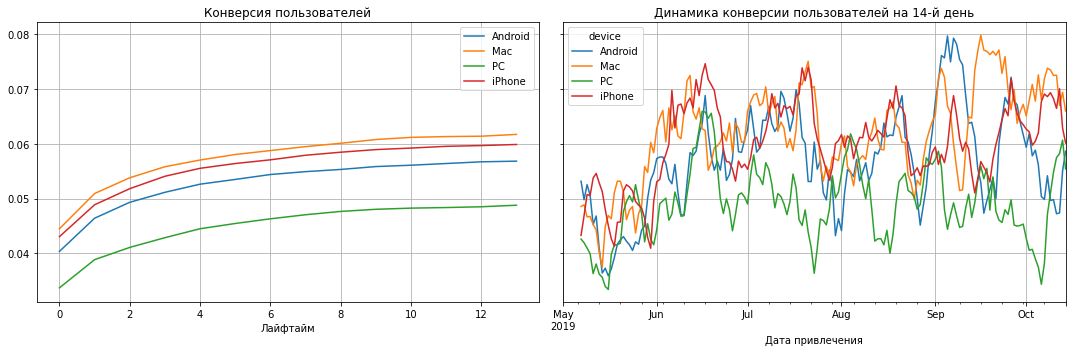

In [135]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Хуже всего у нас конвертируются пользователи PC, но в то же самое время, они единственные окупаются

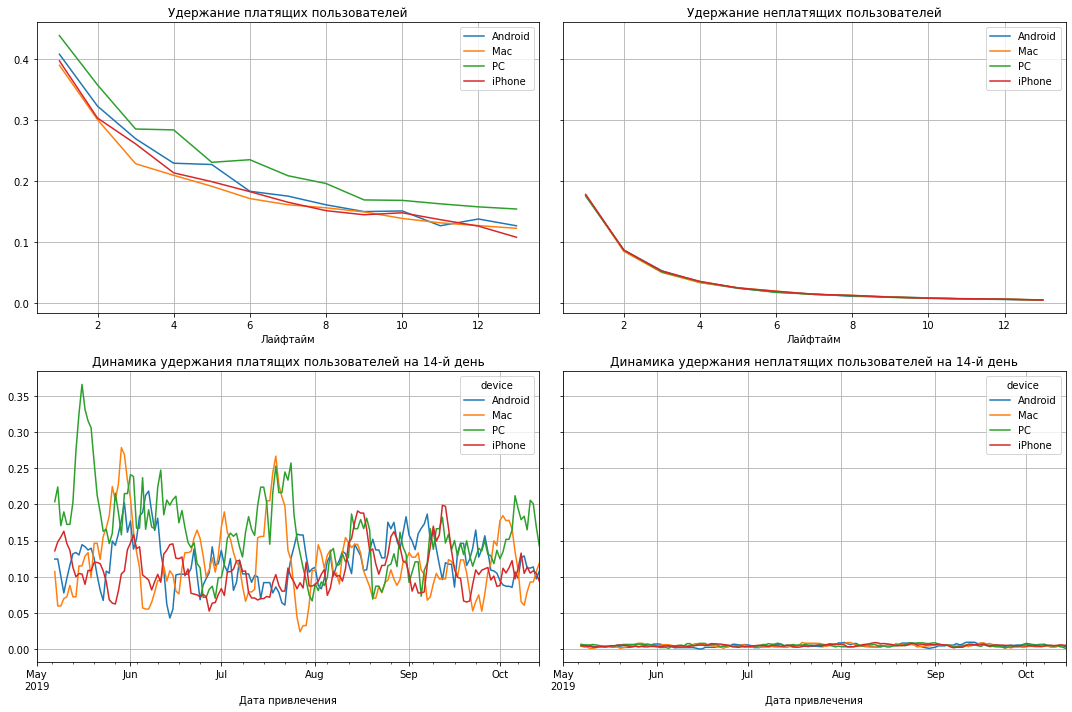

In [136]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удерживаются все пользователи одинаково 

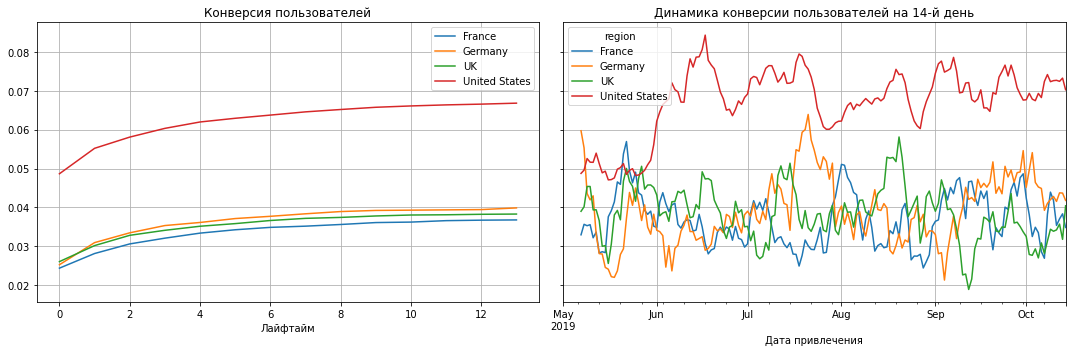

In [137]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конвертируются в покупателей лучше всего пользователи из США

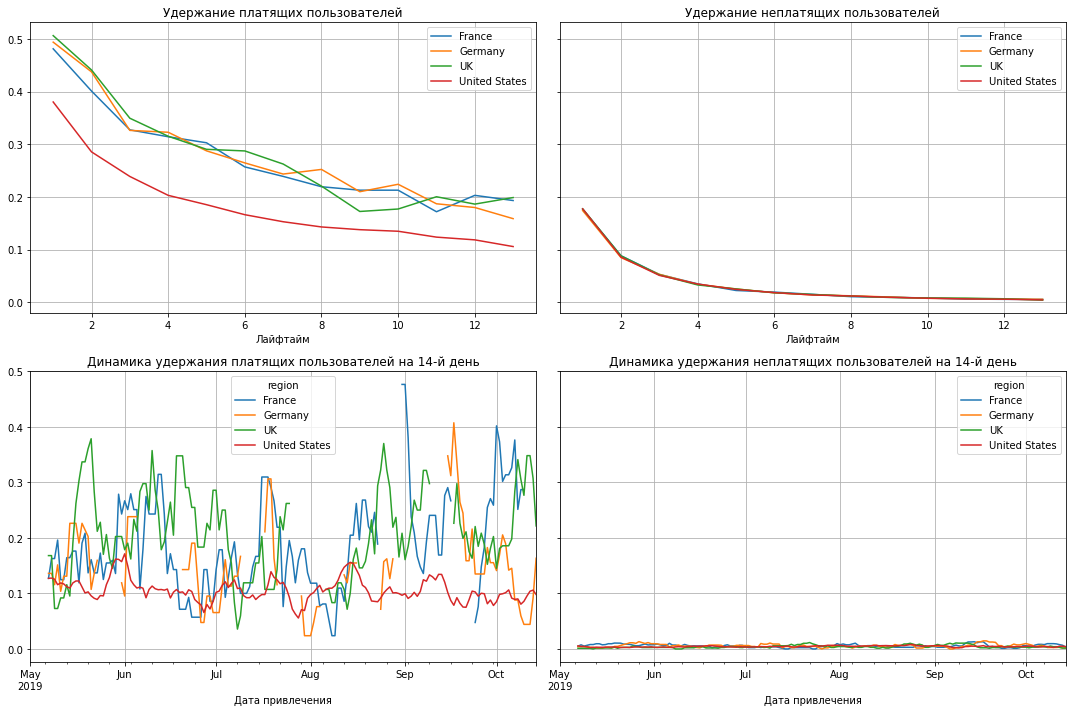

In [138]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Но хуже всего удерживаются так же из США

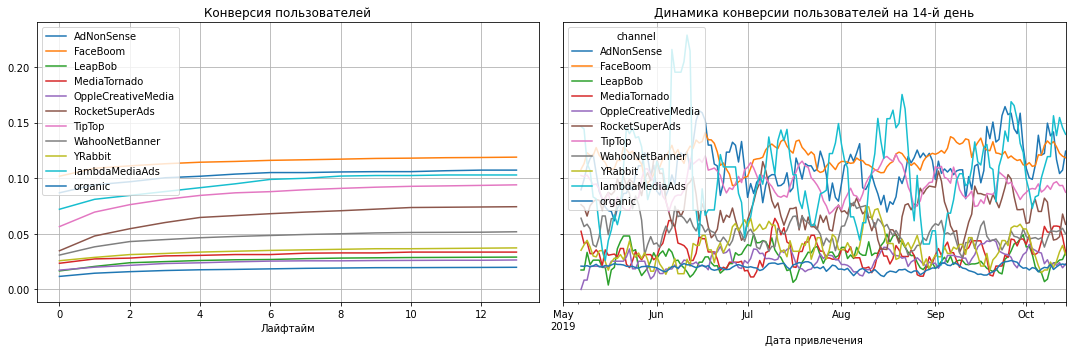

In [139]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

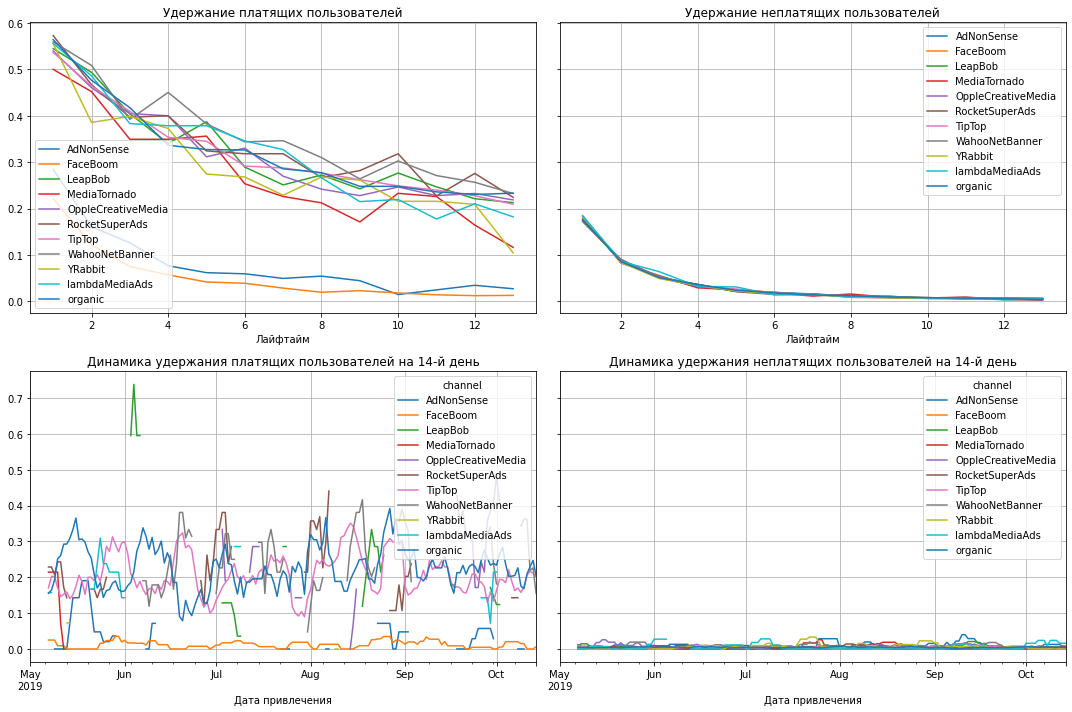

In [140]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конвертируются все привлеченные пользователи не очень хорошо, хуже всех удерживаются пользователи AdNonSense и FaceBoom

In [141]:
profiles.pivot_table(index='region', columns='channel', values='user_id', aggfunc='count').reset_index()

channel         region  AdNonSense  FaceBoom  LeapBob  MediaTornado  \
0               France      1366.0       NaN   2988.0           NaN   
1              Germany      1219.0       NaN   2519.0           NaN   
2                   UK      1295.0       NaN   3046.0           NaN   
3        United States         NaN   29144.0      NaN        4364.0   

channel  OppleCreativeMedia  RocketSuperAds   TipTop  WahooNetBanner  YRabbit  \
0                    2991.0             NaN      NaN          2971.0      NaN   
1                    2562.0             NaN      NaN          2579.0      NaN   
2                    3052.0             NaN      NaN          3003.0      NaN   
3                       NaN          4448.0  19561.0             NaN   4312.0   

channel  lambdaMediaAds  organic  
0                 742.0   6392.0  
1                 649.0   5453.0  
2                 758.0   6421.0  
3                   NaN  38173.0

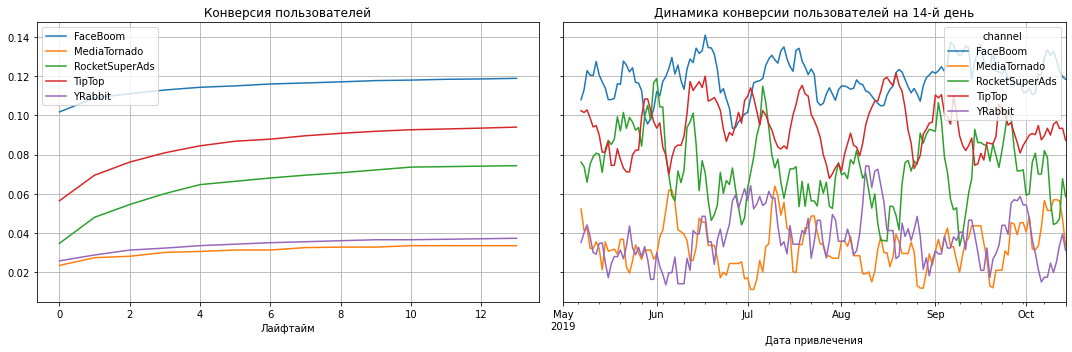

In [142]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_good_USA, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

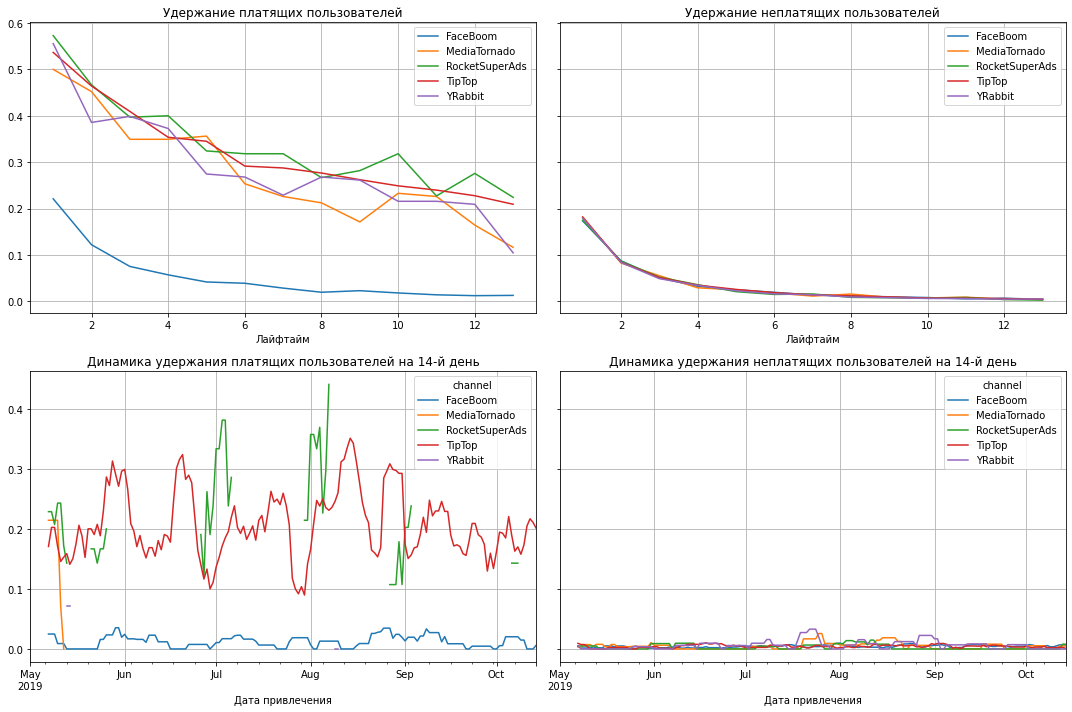

In [143]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_good_USA, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

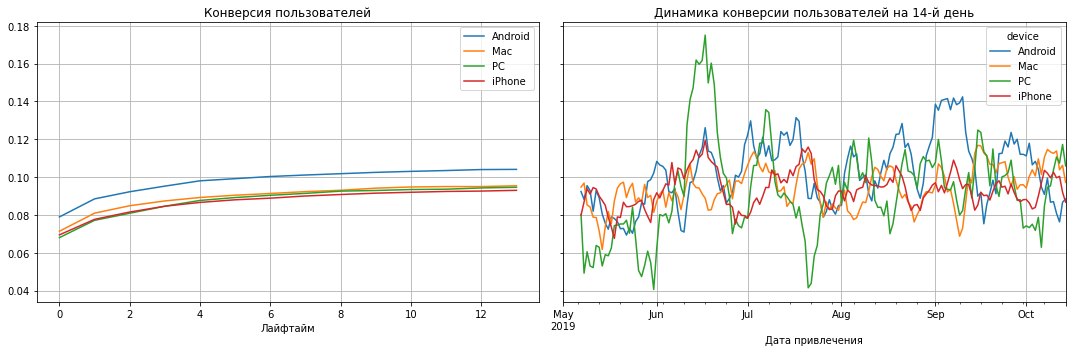

In [144]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_good_USA, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

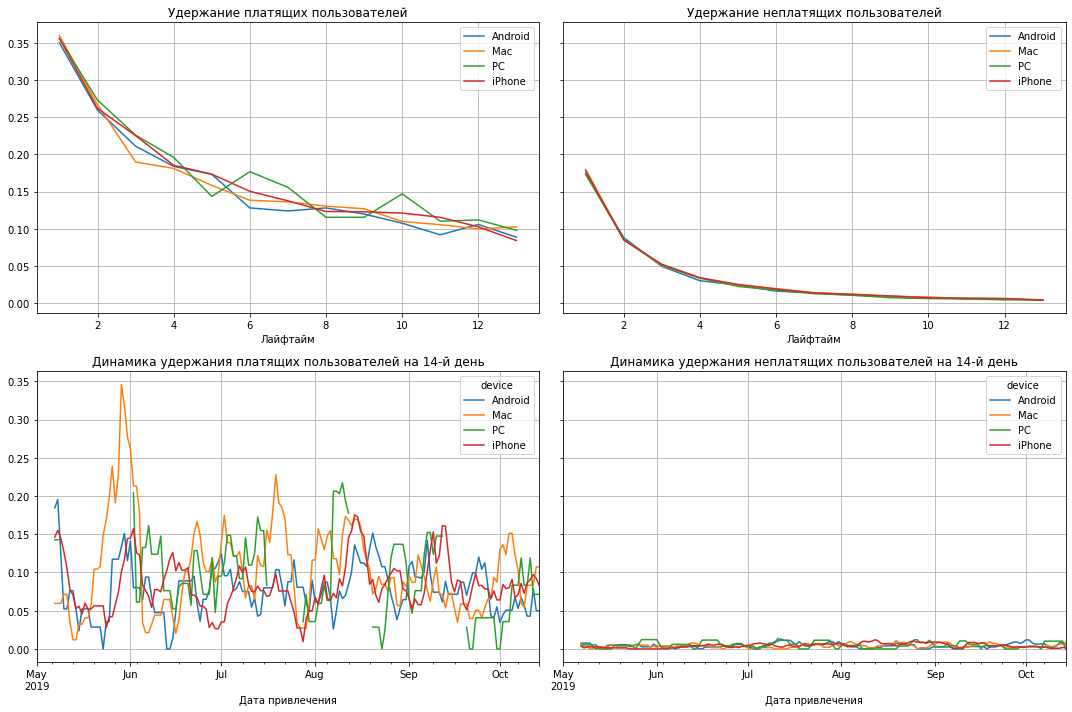

In [145]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_good_USA, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

## Вывод ##

__Цель - разобраться в причинах убытков компании Procrastinate Pro+__

Для анализа нам были представлены данные с 1 мая по 27 октября 2019 года

* логи сервера с данными об посещениях пользователей,
* выгрузка пользовательских покупок за этот период,
* рекламные расходы.

Названия столбцов в данных были приведены к типу snake_case
Данные в столбцах с датой были приведены к типу datetime для дальнейшего удобства анализа

В данных для анализа была представлена инофрмация по 4 странам со следующим количеством пользователей

In [146]:
profiles_region

region  user_id  payer  share
3  United States   100002   6902   6.90
2             UK    17575    700   3.98
0         France    17450    663   3.80
1        Germany    14981    616   4.11

Так же мы имеем следующюю разюивку по устройствам, с которых совершали вход пользователи приложения

In [147]:
profiles_device

device  user_id  payer  share
3   iPhone    54479   3382   6.21
0  Android    35032   2050   5.85
2       PC    30455   1537   5.05
1      Mac    30042   1912   6.36

У приложения 11 точек для рекламирования своего продукта.
С июня месяца расходы на рекламу сильно увеличились и все увелечение пришлось на 2 канала :
 1. FaceBoom
 2. TipTop
 
Эти оба рекламные площадки базируются только на регион США. 
Причем траты на эти 2 канала в несколько раз привосходят траты на все остальные рекламные компании. 
Траты на рекламу в США не окупились за весь период с мая по октябрь. А бюджет только рос. 

Но платформа FaceBoom показала неплохую конверсию. В целом стоимость одного пользователя с этой площдки увеличивалась с затратами на превлечение.

А платформа TipTop не смогла окупить привлеченных пользователей. 

Так же хотелось бы обратить внимание на устройства входа, окупаются только пользователи PC

По итогам анализа были выделены следющие проблемы
    
    1. Слишком большие траты на канал привлечения TipTop и FaceBoom - которая не привела к пропорциональному увелечению притока клиентов. 
    Рекомендация: пересмотреть маркетинговую стратегию и сократить траты на рекламу по этим каналам. Обратить внимание на YRabbit, MediaTornado и RocketSuperAds. Последний в ососбенности, он показывает хорошую конверсию и удержание пользователя.
    
    2. Пользователи из США хорошо конвертируются, но плохо удерживаются. Причем это не зависит от устройства, которым пользуется клиент. 
    Рекомендация: Необходимо отработать данную проблему, возможно помогут напоминания о сервисе в виде смс-уведомлений или email. Так же могут быть проблемы в недовольстве в сервисе, но для ответа на данный вопрос нам не достаточно данных
    
    3. Еще одна проблема FaceBoom - имеем хорошую конверсию, но плохое удержание клиента
    
    4. Все страны: Германия, Франция и Англия окупают рекламу. Но Англия показывает самые хорошие результаты. 
    Рекомендации: стоит рассмотреть регион Англии, как потонциально прибыльный и показывающий хорошие показатели. Стоит направить бюджет на рекламу в этом регионе. Особенно на канал lambdaMediaAds - хорошая конверсия, хорошая окупаемость 
    
    5. Не окупается рекламный канал в Англии AdNonSense